# 5.3. Experiments and Evaluation

### Utility Code

In [1]:
# Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
import numpy as np
from typing import List, Callable
import warnings

warnings.filterwarnings(
    "ignore"
)  # Disable long warnings when NaN values are encountered

In [2]:
# Constants
# color palette source: https://www.practicalpythonfordatascience.com/ap_seaborn_palette

geographical_palette = sns.color_palette("terrain", 8)
orbital_palette = sns.color_palette("Dark2", 8)
latitudinal_palette = sns.color_palette("tab10", 8)

qualitative_case_palettes = {
    "Landlocked": geographical_palette,
    "Coastal": geographical_palette,
    "IntraOrbital": orbital_palette,
    "TransOrbital": orbital_palette,
    "Polar": latitudinal_palette,
    "Equatorial": latitudinal_palette,
}

directions = ["East", "West"] #, "North", "South"]

imax_list = ["OFF", "3", "3", "9"]

log_directory = "../../simulator/Logs/"

In [3]:
# Utility functions
from abc import ABC

def load_data(relative_path: str):
    # TODO: should be named load_csv_data
    """Load CSV data."""
    path = os.path.join(log_directory, relative_path)
    if not os.path.isfile(path):
        raise Exception(f"The path {path} does not exist.")
    return pd.read_csv(path)


def load_json_data(relative_path: str):
    """Load JSON data."""
    path = os.path.join(log_directory, relative_path)
    if not os.path.isfile(path):
        raise Exception(f"The path {path} does not exist.")
    with open(path) as file:
        data = json.load(file)
    return pd.DataFrame(data["latencies"])


class Plot(ABC):
    def __init__(self):
        raise NotImplementedError
    
    def plot(self):
        """Draw a single plot."""
        raise NotImplementedError

    def multi_plot(self):
        """Draw multiple plots."""
        raise NotImplementedError


def graph(plot_fn, qualitative_case, imax=1, reps=1, **kwargs):
    """Plot the results of the plot function for each direction on a single graph.

    To enable RDiS, set imax to a value greater than 1.
    """
    imax = f"{imax}" if imax != 1 else "OFF"

    # palette = qualitative_case_palettes[qualitative_case]
    for direction in directions:
        plot_fn(qualitative_case, direction, imax, reps, **kwargs) # TO BE HONEST THIS SEEMS A BIT OF A USELESS FUNCTION (PLOT_RESULTS DOES THE SAME THING MORE OR LESSs)

## 1. Network Performance relative to $i_\text{max}$
Plots the network performance relative to $i_\text{max}$ for $i_\text{max} \in \{3, 6, 9\}$.

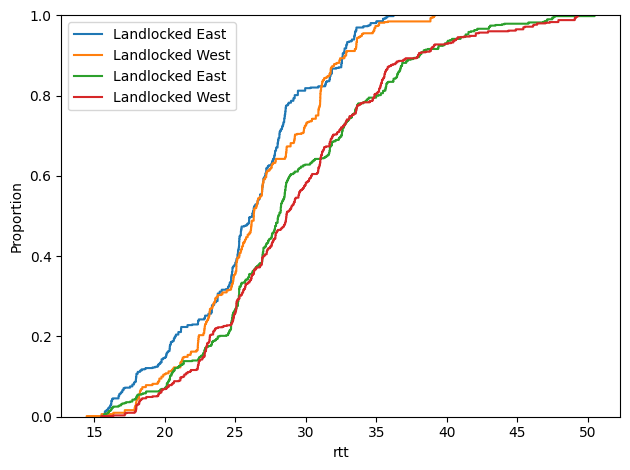

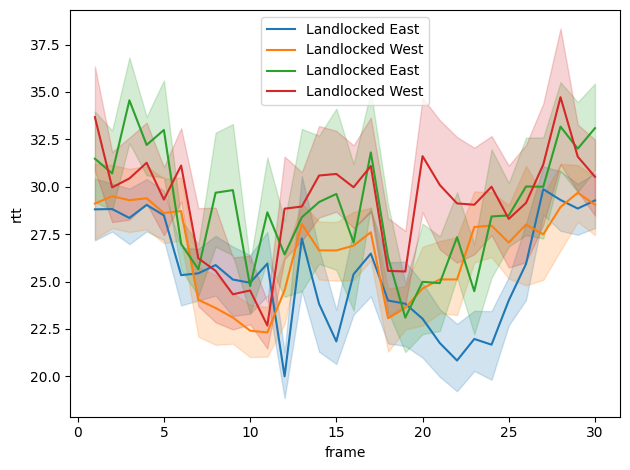

In [16]:
valid_types = {"cdf", "time-series"}

# I think the stuff below is mostly utility functions. Some of this needs to be cleaned up by the way.


class MedianLatency(Plot):
    def __init__(self):
        self.data_df = pd.DataFrame()
        pass

    def get_data(self, scenario: str, direction: str, imax: int, reps: int):
        # Concatenate data from different iterations into a single DataFrame.
        aggregate_data = []
        for i in range(0, reps):
            filename = f"{scenario}_{direction}_{imax}_{i:03d}/rtt.json"
            data = load_json_data(filename).explode("rtt", ignore_index=True)
            data["direction"] = direction
            aggregate_data.append(data)
        return pd.concat(aggregate_data, axis=0, ignore_index = True)


    def cdf_plot(self, scenario, direction, data_df):
        
        # Plot the data
        sns.ecdfplot(
            data=data_df,
                x="rtt",
                # y="rtt",
                label=(
                    f"{scenario} {direction}"
                    if data_df["rtt"].notna().any()
                    else "__nolegend__"
                ),
                legend=True,
                # palette=palette,
                # hue="direction",
        )

    def timeseries_plot(self, scenario, direction, data_df):
        # Plot the data
        sns.lineplot(
            data=data_df,
                x="frame",
                y="rtt",
                label=(
                    f"{scenario} {direction}"
                    if data_df["rtt"].notna().any()
                    else "__nolegend__"
                ),
                legend=True,
                # palette=palette,
                # hue="direction",
        )

        pass

    def plot(self, scenario: str, direction: str, imax: int, reps: int, **kwargs):
        """
        NOTE: plot_type defaults to line
        """
        assert(reps >= 0)
        
        data_df = self.get_data(scenario, direction, imax, reps)

        if "plot_type" in kwargs and kwargs["plot_type"] == "cdf":
            self.cdf_plot(scenario, direction, data_df)
        else:
            self.timeseries_plot(scenario, direction, data_df)


    def single_plot(self, scenario: str, direction: str, imax: int, reps: int, **kwargs):
        self.plot(scenario, direction, imax, reps, **kwargs)
        plt.tight_layout()
        plt.legend()
        plt.show()
    

    def multi_plot(self, scenario: str, directions: List[str], imax_list: List[str], reps: int, **kwargs):
        """Plot the results for all combinations of qualitative cases and a given imax value.

        Args:
            plot_fn (Callable): _description_
            qualitative_case (str): _description_
            imax_list (List[int]): _description_
            reps (int): _description_
        """
        for imax in imax_list:
            for direction in directions:
                self.plot(scenario, direction, imax, reps, **kwargs)
        plt.tight_layout()
        plt.legend()
        plt.show()
            
        #     pass
        # sns.set_palette(qualitative_case_palettes[qualitative_case])

        # if "plot_type" in kwargs and kwargs["plot_type"] == "bar-plot":
        #     # and kwargs["bar-plot"]: 
        #     # DO A BAR PLOT. TO BE FAIR, ITS A BIT DIFFFERENTLY MADED. IT SHOULD BE A DIFFERENT FUNCTION ENTIRELY.
        #     data = list()
        #     for imax in imax_list:
        #         imax = f"{imax}" if imax != 1 else "OFF"

        #         data.append({
        #                 "imax" : imax,
        #                 "probability" : plot_fn(qualitative_case, "East",  imax=imax, reps=reps, **kwargs)
        #             })
        #     data = pd.DataFrame(data)
        #     print(data)
        #     sns.barplot(
        #         data=data,
        #         x="imax", # {direction}",
        #         y="probability",
        #     # color=palette[idx],
        #     # ax=ax,
            
        #     # label=f"{qualitative_case} {direction}",
        #         legend=True
        #     )
        #     pass
        # # elif "plot_type" in kwargs and kwargs["plot_type"] == "expected":

        # else:
        #     for imax in imax_list:
        #         graph(plot_fn, qualitative_case, imax=imax, reps=reps, **kwargs)

        
        # plt.tight_layout()
        # plt.legend()
        # plt.show()
        # pass




# def plot_median_latency2(case, direction, imax, reps, **kwargs):
#     """
#     NOTE: plot_type defaults to line
#     """

#     # Concatenate data from different iterations into a single DataFrame.
#     data_list = []
#     for i in range(0, reps):  # ran 100 instances.
#         filename = f"{case}_{direction}_{imax}_{i:03d}/rtt.json"
#         # assert(os.path.isfile(filename))
#         i_data = load_json_data(filename).explode("rtt", ignore_index=True)
#         i_data["direction"] = direction
#         data_list.append(i_data)
#     data_df = pd.concat(data_list, axis=0, ignore_index = True)

#     # Choose the plot function
#     plot_fn = None
#     params = {"x" : None, "y" : None}
#     if kwargs["plot_type"] == "cdf":
#         plot_fn = sns.ecdfplot
#         params["x"] = "rtt"
#     else:
#         plot_fn = sns.lineplot
#         params["x"] = "frame"
#         params["y"]= "rtt"

#     # Plot the data
#     plot_fn(
#         data=data_df,
#             x=params["x"],
#             y=params["y"],
#             label=(
#                 f"{case} {direction}"
#                 if data_df["rtt"].notna().any()
#                 else "__nolegend__"
#             ),
#             legend=True,
#             # palette=palette,
#             # hue="direction",
#     )

#     return True


# final_data = pd.DataFrame()
# experiment_dataframes: List[pd.DataFrame] = []


''' 
KEEP FOR MULTIPLE DISCERNIBLE PLOTS.
def show_plot(fig, axs):
    
    for ax in np.ravel(axs):  # Flatten the array of Axes objects
        # ax.set_xlabel("Snapshot")
        # ax.set_ylabel("Latency (ms)")
        ax.tick_params(axis="y", labelcolor="black")
        ax.grid(True)

        # Adjust the fill color of the boxplot to be transparent
        for artist in ax.artists:
            artist.set_facecolor((1, 1, 1, 0.5))  # Set fill color to transparent

        # Remove the subplot if there are no lines.
        if len(ax.get_lines()) == 0:
            fig.delaxes(ax)

    plt.tight_layout()
    plt.legend()
    plt.show()
''' 

def plot_results(plot_fn: Callable, qualitative_case: str, imax_list: List[int], reps: int, **kwargs):
    """Plot the results for all combinations of qualitative cases and a given imax value.

    Args:
        plot_fn (Callable): _description_
        qualitative_case (str): _description_
        imax_list (List[int]): _description_
        reps (int): _description_
    """
    sns.set_palette(qualitative_case_palettes[qualitative_case])

    if "plot_type" in kwargs and kwargs["plot_type"] == "bar-plot":
        # and kwargs["bar-plot"]: 
        # DO A BAR PLOT. TO BE FAIR, ITS A BIT DIFFFERENTLY MADED. IT SHOULD BE A DIFFERENT FUNCTION ENTIRELY.
        data = list()
        for imax in imax_list:
            imax = f"{imax}" if imax != 1 else "OFF"

            data.append({
                    "imax" : imax,
                    "probability" : plot_fn(qualitative_case, "East",  imax=imax, reps=reps, **kwargs)
                })
        data = pd.DataFrame(data)
        print(data)
        sns.barplot(
            data=data,
            x="imax", # {direction}",
            y="probability",
        # color=palette[idx],
        # ax=ax,
        
        # label=f"{qualitative_case} {direction}",
            legend=True
        )
        pass
    # elif "plot_type" in kwargs and kwargs["plot_type"] == "expected":

    else:
        for imax in imax_list:
            graph(plot_fn, qualitative_case, imax=imax, reps=reps, **kwargs)

    
    plt.tight_layout()
    plt.legend()
    plt.show()

# plot_median_latency("Landlocked", "East", "3", 5, plot_type="lineplot")

sns.set_palette(latitudinal_palette)
MedianLatency().multi_plot("Landlocked", ["East", "West"], ["3", "6"], 5, plot_type="cdf")
MedianLatency().multi_plot("Landlocked", ["East", "West"], ["3", "6"], 5, plot_type="lineplot")

In [5]:
############################################
# Currently contains eastwards, westwards, #
# northwards, and southwards directions.   #
# Directions, i_maxes, and cases are all   # 
# in the same graph (for now)              #
# i_max \in {1, 3, 6, 9}                   #
############################################

sns.set_palette(geographical_palette)

geographical_cases = list(qualitative_case_palettes.keys()) 


# Cumulative Distribution Function (of RTT)
# TODO: WRITE THIS CORRECTLY.
# for geographical_case in geographical_cases:
#     MedianLatency(plot_median_latency, geographical_case, imax_list=imax_list, reps=100, plot_type="cdf")

# # # Time-series Line Plot
# for geographical_case in geographical_cases:
#     plot_results(plot_median_latency, geographical_case, imax_list=imax_list, reps=100, plot_type="line-plot")


Exception: The path ../../simulator/Logs/Landlocked_East_OFF_001/rtt.json does not exist.

## 2. Simulated Probability of Congestion relative to $i_\text{max}$
Plot the probability of congestion relative to $i_\text{max}$ using spare capacity data retrieved from the simulator for $i_\text{max} \in \{3, 6, 9\}$..

In [17]:
%%script false --no-raise-error

# TODO: I THINK THIS HASNT PROGRESSED MUCH.

class CongestionProbability(Plot):
    def __init__(self):
        pass

    def get_data(self):
        pass

    def plot(self, scenario: str, direction: str, imax: str):
        total_successes = 0
        total_attempts = 0
        for i in range(0, reps):
            filename = f"{scenario}_{direction}_{imax}_{i:03d}/attack.csv"
            data = load_data(filename)
            if 0.0 in data["FINAL CAPACITY"].value_counts():
                total_successes += data["FINAL CAPACITY"].value_counts()[0.0]
            total_attempts += len(data)
        probability = total_successes/total_attempts
        return probability
        sns.barplot(
            x=f"{qualitative_case}", # {direction}",
            y=probability,
            # color=palette[idx],
            # ax=ax,
            
            label=f"{qualitative_case} {direction}",
            legend=True
        )
        # return True
        # pass

    def single_plot(self):

        pass

    def multi_plot(self):
        pass

def plot_probability_congestion(qualitative_case, direction, imax, reps, **kwargs) -> float:
    total_successes = 0
    total_attempts = 0
    for i in range(0, reps):
        filename = f"{qualitative_case}_{direction}_{imax}_{i:03d}/attack.csv"
        data = load_data(filename)
        if 0.0 in data["FINAL CAPACITY"].value_counts():
            total_successes += data["FINAL CAPACITY"].value_counts()[0.0]
        total_attempts += len(data)
    probability = total_successes/total_attempts
    return probability
    sns.barplot(
        x=f"{qualitative_case}", # {direction}",
        y=probability,
        # color=palette[idx],
        # ax=ax,
        
        label=f"{qualitative_case} {direction}",
        legend=True
    )
    return True


fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Defence disabled
# graph(plot_probability_congestion, axs[0], geographical_cases)

# for geographical_case in geographical_cases:
#     plot_results(plot_probability_congestion, geographical_case, imax_list={3, 6, 9}, reps=100, plot_type="bar-plot")

# imax = 3
# graph(plot_probability_congestion, ax=axs[1], imax=3)

# # imax = 6
# graph(plot_probability_congestion, ax=axs[2], imax=6)

# # imax = 9
# graph(plot_probability_congestion, ax=axs[3], imax=9)


for ax in axs:
    # ax.set_xlabel("Snapshot")
    ax.set_ylabel("Probability of Congestion")
    # ax.set_ylim(-.5, 20.5)  # TODO: CHANGE THIS.
    # ax.tick_params(axis="y", labelcolor="black")
    ax.grid(True)

    # Remove the subplot if there is no data.
    if len(ax.get_lines()) == 0:
        fig.delaxes(ax)

plt.tight_layout()
plt.legend()
plt.show()

Couldn't find program: 'false'


## 3. Simulated Expected Malicious Traffic relative to $i_\text{max}$


 East Landlocked 3
mean: 13625.333333333334 
median: 16000.0 
std: 7263.048637731971 
max: 20000.0 
min: 0.0 

 East Landlocked 6
mean: 16512.0 
median: 20000.0 
std: 5965.711964195605 
max: 20000.0 
min: 0.0 

 East Landlocked 9
mean: 17250.666666666668 
median: 20000.0 
std: 5301.811258720607 
max: 20000.0 
min: 0.0 

 West Landlocked 3
mean: 13886.666666666666 
median: 16000.0 
std: 6897.560994398385 
max: 20000.0 
min: 0.0 

 West Landlocked 6
mean: 16530.666666666668 
median: 20000.0 
std: 5725.846778366672 
max: 20000.0 
min: 0.0 

 West Landlocked 9
mean: 17412.0 
median: 20000.0 
std: 5205.569643990893 
max: 20000.0 
min: 0.0 


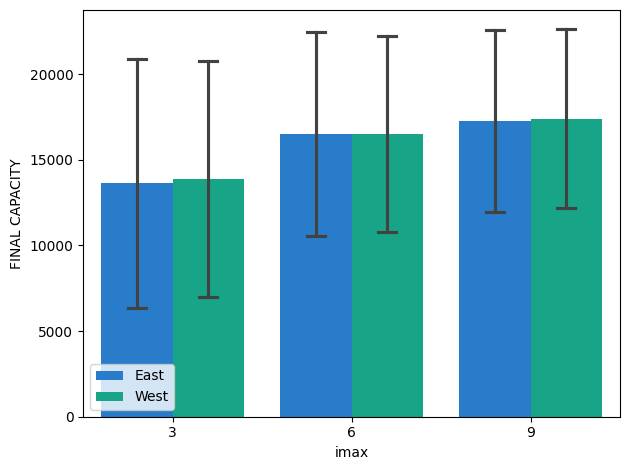

In [22]:
sns.set_palette(geographical_palette)

class ExpectedCapacity(Plot):
    def __init__(self):
        pass

    def _get_data(self, scenario: str, direction: str, imax_list: List[int], reps: int) -> pd.DataFrame:
        aggregate_data = []
        # print(reps)
        for direction in directions: # TODO: DIRECTIONS IS IMPORTANT TOO> NEED TO USE THIS.
            for imax in [3, 6, 9]: #kwargs["imaxes"]:
                # print(imax)
                imax = f"{imax}" if imax != 1 else "OFF"
                agg_data = []
                # Concatenate data from different iterations into a single DataFrame.
                for i in range(0, reps):  # ran 100 instances.
                    filename = f"{scenario}_{direction}_{imax}_{i:03d}/attack.csv"
                    # assert(os.path.isfile(filename))
                    i_data = load_data(filename).explode("FINAL CAPACITY", ignore_index=True)
                    # i_data['FINAL CAPACITY'] = i_data['FINAL CAPACITY'].apply(lambda x: abs(x - 20000)) # TODO: AND MAKE SURE ITS NOT IN MBITS BUT IN GBITS PER SEC
                    i_data["direction"] = direction
                    i_data["imax"] = imax
                    agg_data.append(i_data)
                new =  pd.concat(agg_data, axis=0, ignore_index = True)
                print(f"\n {direction} {scenario} {imax}")
                print("mean: {} ".format(new["FINAL CAPACITY"].mean(axis=0)))
                print("median: {} ".format(new["FINAL CAPACITY"].median(axis=0)))
                print("std: {} ".format(new["FINAL CAPACITY"].std(axis=0)))
                print("max: {} ".format(new["FINAL CAPACITY"].max(axis=0)))
                print("min: {} ".format(new["FINAL CAPACITY"].min(axis=0)))
                aggregate_data.append(new)
                # display(i_data)
                
        return pd.concat(aggregate_data, axis=0, ignore_index = True)

    def plot(self, scenario: str, direction: str, imax_list: List[str], reps: int, **kwargs):
        assert(reps >= 0)

        data_df = self._get_data(scenario, direction, imax_list, reps)

        # if "plot_type" in kwargs and kwargs["plot_type"] == "cdf":
        #     self.cdf_plot(scenario, direction, data_df)
        # else:
        #     self.timeseries_plot(scenario, direction, data_df)

        # sns.barplot(
        #     x="case direction",
        #     y="mean",
        #     yerr="stddev",
        #     data=plot_data,
        #     color=palette[idx],
        #     # ax=ax,
        #     label="{case} {direction}",
        # )

                # Plot the data
        sns.barplot(
            data=data_df,
                x="imax",
                y="FINAL CAPACITY",
                # label=(
                #     f"{scenario} {direction}"
                #     if data_df["FINAL CAPACITY"].notna().any()
                #     else "__nolegend__"
                # ),
                legend=True,
                # palette=palette,
                hue="direction",
                errorbar="sd",
                capsize=.2,
                estimator=np.mean,
                # err_style="bars", 
                # errorbar=("sd", 1)
                # yerr=data_df[""]
        )

        # data_df = 
        pass

    def single_plot(self, scenario: str, direction: str, imax_list: int, reps: int, **kwargs):
        self.plot(scenario, direction, imax_list, reps, **kwargs)
        plt.tight_layout()
        plt.legend()
        plt.show()

    def multi_plot(self):
        pass

    def set_palette(self):
        pass

def plot_expected_capacity(case, direction, defence, palette, idx):
    filename = f"{case}_{direction}_{defence}"
    data = load_data(f"{filename}/{filename}.csv")
    plot_data = pd.DataFrame(
        {
            "case direction": [f"{case} {direction}"],
            "mean": data.mean()["FINAL CAPACITY"],
            "stddev": data.std()["FINAL CAPACITY"],
        }
    )

    sns.barplot(
        x="case direction",
        y="mean",
        yerr="stddev",
        data=plot_data,
        color=palette[idx],
        # ax=ax,
        label="{case} {direction}",
    )


# def plot_expected_capacity(scenario: str)

def plot_expected_capacity(scenario: str, direction: str, imax: str, reps: int, **kwargs):
    """Plot the expected capacity as a CDF or a timeseries line plot.

    For a CDF, set plot_type = 'cdf'. For a timeseries line plot, set
    plot_type = 'line'.

    Args:
        scenario (str): Qualitative scenario.
        direction (str): Target link orientation.
        imax (str): Value of RiDS imax parameter.
        reps (int): Number of iterations.
    """


    # Choose the plot function
    plot_fn = None
    params = {"x" : None, "y" : None}
    if kwargs["plot_type"] == "cdf":
        plot_fn = sns.ecdfplot
        params["x"] = "FINAL CAPACITY" # NOTE: THIS IS **NOT** OVER TIME SERIES. THIS IS IN GENREAL!
    else:
        plot_fn = sns.lineplot
        params["x"] = "IMAX"
        params["y"]= "FINAL CAPACITY" # THIS IS TIME SERIES!

    # Plot the data
    # plot_fn(
    #     data=data_df,
    #         x=params["x"],
    #         y=params["y"],
    #         label=(
    #             f"{scenario} {direction} {imax}"
    #             if data_df["FINAL CAPACITY"].notna().any()
    #             else "__nolegend__"
    #         ),
    #         legend=True,
    #         # palette=palette,
    #         # hue="direction",
    # )
    # print(f"\n {direction} {scenario} {imax}")
    # print("mean: {} ".format(data_df["FINAL CAPACITY"].mean(axis=0)))
    # print("std: {} ".format(data_df["FINAL CAPACITY"].std(axis=0)))

    return True


# SHOULD DO CLASSES, ETC.

# e = pd.DataFrame()
# class ExpectedCapacity2:

#     def ___init__(self):
#         pass

#     def plot_fn(self, reps=1, **kwargs):
#         """Plot the expected capacity as a CDF or a timeseries line plot.

#         For a CDF, set plot_type = 'cdf'. For a timeseries line plot, set
#         plot_type = 'line'.

#         Args:
#             scenario (str): Qualitative scenario.
#             direction (str): Target link orientation.
#             imax (str): Value of RiDS imax parameter.
#             reps (int): Number of iterations.
#         """
#         global e
#         # check that the correct arguments are present.
#         assert "scenario" in kwargs
#         assert "direction" in kwargs
#         assert "imaxes" in kwargs
#         # assert {"scenario", "direction", "imaxes"} in kwargs
#         scenario = kwargs["scenario"]
#         direction = kwargs["direction"]
        

#         aggregate_data = []
#         # print(reps)
#         for direction in directions:
#             for imax in [3, 6, 9]: #kwargs["imaxes"]:
#                 # print(imax)
#                 imax = f"{imax}" if imax != 1 else "OFF"
#                 agg_data = []
#                 # Concatenate data from different iterations into a single DataFrame.
#                 for i in range(0, reps):  # ran 100 instances.
#                     filename = f"{scenario}_{direction}_{imax}_{i:03d}/attack.csv"
#                     # assert(os.path.isfile(filename))
#                     i_data = load_data(filename).explode("FINAL CAPACITY", ignore_index=True)
#                     # i_data['FINAL CAPACITY'] = i_data['FINAL CAPACITY'].apply(lambda x: abs(x - 20000)) # TODO: AND MAKE SURE ITS NOT IN MBITS BUT IN GBITS PER SEC
#                     i_data["direction"] = direction
#                     i_data["imax"] = imax
#                     agg_data.append(i_data)
#                 new =  pd.concat(agg_data, axis=0, ignore_index = True)
#                 print(f"\n {direction} {scenario} {imax}")
#                 print("mean: {} ".format(new["FINAL CAPACITY"].mean(axis=0)))
#                 print("median: {} ".format(new["FINAL CAPACITY"].median(axis=0)))
#                 print("std: {} ".format(new["FINAL CAPACITY"].std(axis=0)))
#                 print("max: {} ".format(new["FINAL CAPACITY"].max(axis=0)))
#                 print("min: {} ".format(new["FINAL CAPACITY"].min(axis=0)))
#                 aggregate_data.append(new)
#                 # display(i_data)
                
#         data_df = pd.concat(aggregate_data, axis=0, ignore_index = True)
#         # display(data_df)
#         # e = data_df
#         # return


#         # Choose the plot function
#         # plot_fn = None
#         params = {"x" : None, "y" : None}
#         # if kwargs["plot_type"] == "cdf":
#         #     plot_fn = sns.ecdfplot
#         #     params["x"] = "FINAL CAPACITY" # NOTE: THIS IS **NOT** OVER TIME SERIES. THIS IS IN GENREAL!
#         # else:
#             # plot_fn = sns.lineplot
#         params["x"] = "imax"
#         params["y"]= "FINAL CAPACITY" # THIS IS TIME SERIES!

#         # Plot the data
#         sns.barplot(
#             data=data_df,
#                 x=params["x"],
#                 y=params["y"],
#                 # label=(
#                 #     f"{scenario} {direction}"
#                 #     if data_df["FINAL CAPACITY"].notna().any()
#                 #     else "__nolegend__"
#                 # ),
#                 legend=True,
#                 # palette=palette,
#                 hue="direction",
#                 errorbar="sd",
#                 capsize=.2,
#                 estimator=np.mean
#                 # err_style="bars", 
#                 # errorbar=("sd", 1)
#                 # yerr=data_df[""]
#         )

#         return True

#     def plot_results(self,qualitative_case,  imax_list: List[int], reps, **kwargs):
#         # for direction in directions:
#         self.plot_fn(reps=reps, scenario=qualitative_case, direction="Eat", **kwargs) 
#             # return
#         pass

# Cumulative Distribution Function (of RTT)
for geographical_case in {"Landlocked"}:
    ExpectedCapacity().single_plot(geographical_case, "East", imax_list={3, 6, 9}, reps=100, plot_type="line", imaxes=[3, 6, 9])

# display(e)
# I THINK CDF IS ACTUALLY NOT SO USEFUL HERE! I THINK ITS BETTER TO DO A TYPICAL LINE PLOT OF THE MEDIAN + THE STANDARD DEVIATION!
# PUT ALL THE DATA INTO ONE DATAFRAME FOR EAHC IMAX. THEN MAKE A LINEPLOT. BUT ONLY AFTER!!!!
# fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Defence disabled
# graph(plot_expected_capacity, axs[0], geographical_cases)

# # imax = 3
# graph(plot_expected_capacity, ax=axs[1], imax=3)

# # imax = 6
# graph(plot_expected_capacity, ax=axs[2], imax=6)

# # imax = 9
# graph(plot_expected_capacity, ax=axs[3], imax=9)


# for ax in axs:
#     # ax.set_xlabel("Snapshot")
#     ax.set_ylabel("Expected Spare Capacity")
#     # ax.set_ylim(-.5, 20.5)  # TODO: CHANGE THIS.
#     # ax.tick_params(axis="y", labelcolor="black")
#     ax.grid(True)

#     # Remove the subplot if there is no data.
#     if len(ax.get_lines()) == 0:
#         fig.delaxes(ax)

# plt.tight_layout()
# plt.legend()
# plt.show()